In [1]:
import pandas as pd
import numpy as np
import re
import pickle
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer
import sklearn.preprocessing as Preprocessing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# read the movie metadata
movie_data = pd.read_csv("data/top1000_movies_2011_2016_tmdb_imdb.csv")

# eliminate movies without genre_ids
movie_data = movie_data[pd.notnull(movie_data["genre_ids"])]
print "Dimension of the data: ", movie_data.shape

Dimension of the data:  (5996, 20)


### Correct the format of the texts
Some of the movie title and overviews are misformatted with error or in another language, and will cause error in the following analysis. The misformatted texts are checked and removed first. 

#### Movie titles

In [3]:
# extract movie titles
corpus_title = movie_data['title'].values

In [4]:
### obtain the index that causes encoding error
bad_title_index = []
for i in range(len(corpus_title)):
    try:
        corpus_title[i].encode('utf-8')
    except:
        bad_title_index.append(i)

# check the bad title index
print "The number of misformatted movie titles: ", len(bad_title_index)
print bad_title_index

The number of misformatted movie titles:  4
[167, 1082, 2856, 2860]


In [5]:
### examine each words in the misformatted movie titles 
### remove the words that cause encoding problems
for i in bad_title_index:
    bad_title = corpus_title[i].split()
    for s in bad_title:
        try:
            m = s.encode('utf-8')
        except:
            bad_title.remove(s)
    
    #re-join the words with the problematic words being removed
    corpus_title[i] = " ".join(bad_title)          
    print corpus_title[i]     

Dedemin
Berlin
A??k
Hititya Madalyonun


#### Movie Overview
When we first explored the number of movie titles with encoding errors, it seems only a moderate amount of movie titles have thie issue. However, when it comes to the movie overview, there is an extensive number of movie overviews which has encoding problems. Thus, it is decided that we cannot simply deleted the movies with error and instead we should only remove the problematic words. In addition, there are a lot of movies missing overviews. The missing overviews are coded as "Missingval".

In [6]:
# extract movie overview
corpus_overview = movie_data['overview'].values

In [7]:
# obtain the index that causes encoding error
bad_ov_index = []
for i in range(len(corpus_overview)):
    try:
        corpus_overview[i].encode('utf-8')
    except:
        bad_ov_index.append(i)
        
# check the bad title index
print "The number of misformatted movie overviews: ", len(bad_ov_index)

The number of misformatted movie overviews:  38


In [7]:
### find the index of movie titles with nan
# replace by "missingval", otherwise cause error
# because split cannot be applied to "float" type

null_ov_index = []

for i in range(len(corpus_overview)):
    if str(corpus_overview[i]) == "nan":
        null_ov_index.append(i)

print "The number of movies missing overviews: ", len(null_ov_index)
# encode nan as missingval
# use 'missingval' but not 'missing' because 'missing' can really appear in movie titles
corpus_overview[null_ov_index] = 'missingval'

The number of movies missing overviews:  31


In [8]:
### examine each words in the misformatted movie titles 
### remove the words that cause encoding problems
# overview data was cleaned 10 times 
# (cleaning only a few times still cause encoding error)
for j in range(10):
    bad_ov_unfixed_index =[]
    for i in range(len(corpus_overview)):
        try:
            corpus_overview[i].encode('utf-8')
        except:
            bad_ov_unfixed_index.append(i)

    for k in bad_ov_unfixed_index:
        bad_overview = corpus_overview[k].split()
        for s in bad_overview:
            try:
                m = s.encode('utf-8')
            except:
                bad_overview.remove(s)
        #re-join the words with the problematic words being removed
        corpus_overview[k] = " ".join(bad_overview)            

### Text analysis using bag-of-words

#### Movie titles

In [9]:
# apply bag-of-words to movie titles
# eliminate common stop words
vectorizer = CountVectorizer(stop_words='english')
title_counts = vectorizer.fit_transform(corpus_title)
# convert to array
title_counts = title_counts.toarray()

# word list for title
title_words = vectorizer.get_feature_names()
title_words = np.asarray(title_words)

# format the counts into a dataframe
title_counts_df = pd.DataFrame(title_counts)
title_counts_df.columns = title_words

In [10]:
# count the total occurance of each word
word_count = title_counts_df.sum(axis=0)

# append the total count for each word at the end
title_counts_df = title_counts_df.append(word_count, ignore_index=True)
# change the index name to be more informative
title_counts_df=title_counts_df.rename(index = {title_counts_df.shape[0]:'sum'})

# sort dataframe by the value of the last row
new_columns = title_counts_df.columns[title_counts_df.ix[title_counts_df.last_valid_index()].argsort()]
title_counts_df = title_counts_df[new_columns]
# reverse the columns order
title_counts_df = title_counts_df[title_counts_df.columns[::-1]]

In [11]:
# check the dataframe
title_counts_df.tail()

,christmas,love,live,story,movie,man,life,dead,night,girl,...,myra,naan,mysteria,mysteries,mysterio,mysterious,myth,mythical,myths,knives
5992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5996,120,93,71,66,63,55,54,47,47,41,...,1,1,1,1,1,1,1,1,1,1


#### Movie overviews

In [12]:
# apply bag-of-words 
overview_counts = vectorizer.fit_transform(corpus_overview)
# convert to array
overview_counts = overview_counts.toarray()

# word list for overview
overview_words = vectorizer.get_feature_names()
overview_words = np.asarray(overview_words)

# convert to dataframe 
overview_counts_df = pd.DataFrame(overview_counts)
overview_counts_df.columns = overview_words

In [13]:
# compute the total counts for each word
overview_word_count = overview_counts_df.sum(axis=0)
# append the count for each word at the end
overview_counts_df = overview_counts_df.append(overview_word_count, ignore_index=True)
overview_counts_df.shape

(5997, 25981)

In [14]:
# change the index name to be more informative
overview_counts_df=overview_counts_df.rename(index = {overview_counts_df.shape[0]:'sum'})

# sort dataframe by the value of the last row
ov_new_columns = overview_counts_df.columns[overview_counts_df.ix[overview_counts_df.last_valid_index()].argsort()]
overview_counts_df = overview_counts_df[ov_new_columns]
# reverse the columns order
overview_counts_df = overview_counts_df[overview_counts_df.columns[::-1]]

# check the result
overview_counts_df.tail()

,life,new,world,film,story,young,family,man,love,time,...,majesty,mainstay,mainstage,maimed,maime,mails,mailman,mailhouse,mailboxes,kolb
5992,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5996,1179,1002,919,789,784,751,718,613,592,539,...,1,1,1,1,1,1,1,1,1,1


### Check the word counts
#### Movie titles

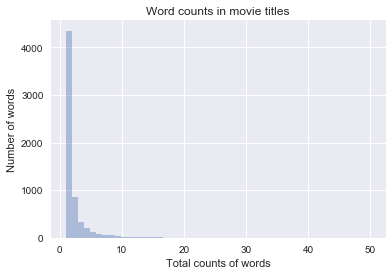

In [22]:
ax = sns.distplot(word_count, kde=False, rug=False, hist_kws={"range": [1,50]})
ax.set(xlabel='Total counts of words', ylabel='Number of words', title = "Word counts in movie titles")

#### Movie overviews

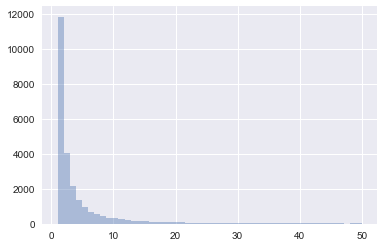

In [23]:
sns.distplot(overview_word_count, kde=False, rug=False, hist_kws={"range": [1,50]})
ax.set(xlabel='Total counts of words', ylabel='Number of words', title = "Word counts in movie oveviews")

### Apply PCA on the text counts
Try to reduce dimensionality using PCA. However, PCA doesn't reduce much of the dimensionality. 

In [24]:
pca = PCA()

### on movie title
title_pca = pca.fit_transform(title_counts_df.iloc[:-1])
# find the #PC explain 90% var
total_var = np.cumsum(pca.explained_variance_ratio_)
n_pc_title = np.where((total_var > 0.9) == True)[0][0]
print "Movie title: The number of PCs capturing 90% of the variability: ", n_pc_title

Movie title: The number of PCs capturing 90% of the variability:  3102


In [19]:
### on movie overview
overview_pca = pca.fit_transform(overview_counts_df[:-1])
total_var = np.cumsum(pca.explained_variance_ratio_)
# find the #PC explain 90% var
n_pc_overview = np.where((total_var > 0.9) == True)[0][0]
print "Movie overviews: The number of PCs capturing 90% of the variability: ", n_pc_overview

Movie overviews: The number of PCs capturing 90% of the variability:  2573


### Prepare the data for fitting the traditional models
#### Format and clean the metadata
Mean imputation on the missing values of quantitative predictors. One-hot-encoding the categorical variables.

In [25]:
##### quantitative predictors

quant_cols = ["popularity", "vote_count" , "runtime", "vote_average"]

### check proportion of missing data
for col in quant_cols:
    print (col)
    print "Missing proportion: ", np.mean(pd.isnull(movie_data[col]))

### read the predictors and convert string into float
# convert df to array
x_quant = movie_data[quant_cols].values

# convert each column to float
for i in range(x_quant.shape[1]):
    x_quant[:, i] = map(float, x_quant[:, i])

### mean imputation on the missing values
for i in range(x_quant.shape[1]):
    col_mean = np.nanmean(x_quant[:, i])
    x_quant[np.isnan(x_quant[:, i]), i] = col_mean

popularity
Missing proportion:  0.0
vote_count
Missing proportion:  0.0
runtime
Missing proportion:  0.165943962642
vote_average
Missing proportion:  0.0


In [26]:
##### categorical predictors

### add release month to the data
release_month = list()

for i in range(movie_data.shape[0]):
    # extract release year
    t = movie_data.iloc[i]["release_date"]
    month = datetime.strptime(t, '%m/%d/%Y').month
    release_month.append(month)
    
# add to the data
movie_data["release_month"] = pd.Series(release_month, index = movie_data.index)

### one-hot-encode categorial variables
cat_cols = ["director", "aspect_ratio", "year", "release_month"]

(5996, 4271)


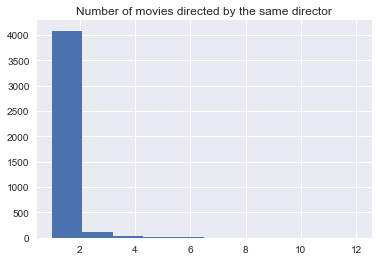

In [32]:
# encode directors first
x_directors = pd.get_dummies(movie_data["director"])
# how many directors in total?
print x_directors.shape  
# number of movies for each director
n_movie_director = x_directors.sum(axis = 0)
# check the histogram
plt.hist(n_movie_director)
plt.title("Number of movies directed by the same director")

Cannot use director information as predictor, since most directors have only 1 movie, and there are a large number of directors. 

In [48]:
# encode the other columns except director
# convert year and month to strings
movie_data["year"] = map(str, movie_data["year"].values)
movie_data["release_month"] = map(str, movie_data["release_month"].values)

cat_cols = cat_cols[1:len(cat_cols)]
x_cat = pd.get_dummies(movie_data[cat_cols], drop_first=True)

In [49]:
##### combine quant and cat predictors

# predictor array with the metadata
x_array = np.concatenate((x_quant, x_cat.values), axis = 1)
x_array.shape

# name of the predictors
x_names = np.concatenate((quant_cols, x_cat.columns), axis = 0)

#### Combine text data with the metadata
Counts of the top words are used for fitting the traditinal models.

In [52]:
# save the first 17 columns of the title (> 30 times)
selected_title_counts = title_counts_df.iloc[:-1, :17].values

# save the first 66 columns of the overview (> 200 times)
selected_overview_counts = overview_counts_df.iloc[:-1, :66].values

# combine with x_array  
x_array = np.concatenate((x_array, selected_title_counts, selected_overview_counts), axis = 1)

### PREPROCESSING: Scale continuous features 
standardize = Preprocessing.StandardScaler()
x_std = standardize.fit_transform(x_array)

#### Extract and clean the response variable

In [5]:
# convert genre ids to list
y = list()
for i in range(movie_data.shape[0]):
    genre = map(int, re.sub("[\[ \] ]", "", movie_data['genre_ids'][i]).split(','))
    y.append(genre)

# binarize response variable (returns array)
binarizer = MultiLabelBinarizer().fit(y)
y_binary = binarizer.transform(y)

In [11]:
# save the order of the genres in the binarized response for later use
pickle.dump(binarizer.classes_, open('data/binarizer_genre_list.p', 'wb'))

In [57]:
# # save the data for the next step
# features_targets_dump = list([x_array, x_std, y_binary])
# pickle.dump(features_targets_dump, open('data/cleaned_data_for_traditional_models.p', 'wb'))